# Azure AI Foundry を使用したシングルエージェントシステム

## 概要

このノートブックでは、Azure AI Foundry プラットフォームを利用してエージェントを作成・管理する方法を学習します。

### 主な学習内容

- **Semantic Kernel で Azure AI Agent を操作する**
   - Foundry で作成済みエージェントを利用する方法
   - Semantic Kernel から作成した Foundry Agent を利用する方法

- **エージェントの作成と設定**
   - Code Interpreter エージェントの作成
   - ツールとリソースの設定

# ライブラリのインポート

Azure AI Foundry エージェントシステムの構築に必要なライブラリをインポートします。

## 主要コンポーネント

- **AzureAIAgent**: Azure AI Foundry エージェントのクライアント
- **AzureAIAgentThread**: Foundry エージェント用のスレッド管理
- **CodeInterpreterTool**: コード実行機能
- **FileSearchTool**: ファイル検索機能

In [2]:
import os
import json
import asyncio
import datetime

from dotenv import load_dotenv, find_dotenv

from IPython.display import Image, display

from azure.identity.aio import DefaultAzureCredential
from azure.ai.agents.models import (
    FileInfo, FileSearchTool, VectorStore,
    CodeInterpreterTool, FilePurpose,
    ListSortOrder
)

from semantic_kernel.agents import (
    ChatCompletionAgent, ChatHistoryAgentThread,
    AzureAIAgent, AzureAIAgentSettings, AzureAIAgentThread
)
from semantic_kernel.connectors.ai.open_ai import AzureChatCompletion
from semantic_kernel.connectors.mcp import MCPStreamableHttpPlugin
from semantic_kernel.contents import (
    ChatMessageContent, FunctionCallContent, FunctionResultContent, AuthorRole, TextContent
)


# 環境変数の取得

Azure AI Foundry プロジェクトと Azure OpenAI Service への接続に必要な認証情報を環境変数から取得します。

In [3]:
load_dotenv(override=True)

PROJECT_ENDPOINT=os.getenv("PROJECT_ENDPOINT")
AZURE_DEPLOYMENT_NAME=os.getenv("AZURE_DEPLOYMENT_NAME")
AZURE_OPENAI_ENDPOINT=os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY=os.getenv("AZURE_OPENAI_API_KEY")

FOUNDRY_FILE_SEARCH_AGENT_ID=os.getenv("FOUNDRY_FILE_SEARCH_AGENT_ID")

# ユーティリティ関数

エージェントの実行結果（テキスト・画像）を表示し、画像ファイルを保存するためのヘルパー関数を定義します。

In [4]:
async def agent_run_outputs(thread_id, agents_client, target_dir="./output_images"):
    """
    指定したスレッドIDのRun実行結果（テキスト・画像）をNotebook上に表示＆画像は保存。
    """
    messages = agents_client.messages.list(thread_id=thread_id, order=ListSortOrder.ASCENDING)
    os.makedirs(target_dir, exist_ok=True)

    async for message in messages:
        # テキスト出力
        if message.text_messages:
            for txt in message.text_messages:
                print(f"{message.role.upper()}: {txt.text.value}")

        # 画像出力
        if hasattr(message, "image_contents"):
            for image_content in message.image_contents:
                file_id = image_content.image_file.file_id
                file_name = f"{file_id}_image_file.png"

                await agents_client.files.save(
                    file_id=file_id,
                    file_name=file_name,
                    target_dir=target_dir
                )
                print(f"Saved image: {file_name}")
                display(Image(filename=f"{target_dir}/{file_name}"))


# プロジェクトクライアントの初期化

Azure AI Foundry プロジェクトへの接続クライアントを初期化します。

In [5]:
# AzureAIAgent クライアントを初期化
project_client = AzureAIAgent.create_client(
    endpoint=PROJECT_ENDPOINT,
    credential=DefaultAzureCredential()
)

# 1. 作成済み Foundry Agent を利用する方法

Azure AI Foundry で事前に作成されたエージェントを取得し、Semantic Kernel から利用します。

# Foundry Agent の取得

In [6]:
file_search_agent_definition = await project_client.agents.get_agent(agent_id=FOUNDRY_FILE_SEARCH_AGENT_ID)

# Semantic Kernel Agent の初期化

In [7]:
agent = AzureAIAgent(
    client=project_client,
    definition=file_search_agent_definition,
)

# スレッドの作成

In [8]:
thread = AzureAIAgentThread(
    client=project_client
)
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: None


# レスポンスを取得

In [9]:
message= (
    "パソコンの保障プランでもっとも安いプランは？"
)

response = await agent.get_response(
    messages=[message],
    thread=thread,
)

await agent_run_outputs(thread.id, project_client.agents)

USER: パソコンの保障プランでもっとも安いプランは？
ASSISTANT: パソコンの保障プランでもっとも安いプランは「1年プラン」で、料金は税込10,000円です。このプランでも修理費用全額カバー、代替機の提供、データ復旧サービス、24時間365日のサポートなどが含まれています【4:3†パソコン保障プラン.html】。


# 2. Foundry Agent の作成方法

新しいエージェントを Azure AI Foundry で作成し、Semantic Kernel から利用します。

# プラグインの作成

In [10]:
code_interpreter = CodeInterpreterTool()

# Foundry Agent の作成

In [11]:
code_interpreter_agent_definition = await project_client.agents.create_agent(
    model=AZURE_DEPLOYMENT_NAME,
    name="code_interpreter_agent",
    instructions=(
        "あなたはコードインタープリターエージェントです。"
        "Pythonコードを実行し、結果を返します。"
        "高度な分析やグラフの出力が得意です。"
    ),
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)

# Semantic Kernel Agent の作成

In [12]:
code_interpreter_agent_definition

{'id': 'asst_uBXnquigi44BS3k57R2Hl56D', 'object': 'assistant', 'created_at': 1753822794, 'name': 'code_interpreter_agent', 'description': None, 'model': 'gpt-4.1', 'instructions': 'あなたはコードインタープリターエージェントです。Pythonコードを実行し、結果を返します。高度な分析やグラフの出力が得意です。', 'tools': [{'type': 'code_interpreter'}], 'top_p': 1.0, 'temperature': 1.0, 'tool_resources': {'code_interpreter': {'file_ids': []}}, 'metadata': {}, 'response_format': 'auto'}

In [13]:
agent = AzureAIAgent(
    client=project_client,
    definition=code_interpreter_agent_definition,
)

# スレッドの作成

In [14]:
thread = AzureAIAgentThread(
    client=project_client
)
print(f"Created Thread. THREAD_ID: {thread.id}")

Created Thread. THREAD_ID: None


# レスポンスの取得

USER: 初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。また、投資せずに貯蓄した場合と比較できるようグラフを出力してください。ラベルやタイトルは英語で出力してください。
ASSISTANT: 20年間、毎年10万円を追加投資し年利回り3.5%で運用した場合の最終的な資産額は「約4,916,736円」となります。

同じ条件で投資せずに貯蓄した場合は「3,000,000円」となります。

上のグラフでは、オレンジ線が投資時、点線が貯蓄の場合の資産推移を示しています。長期運用による複利効果の違いが明らかです。
Saved image: assistant-8y3DsGQyazCYCGvtBtGgHS_image_file.png


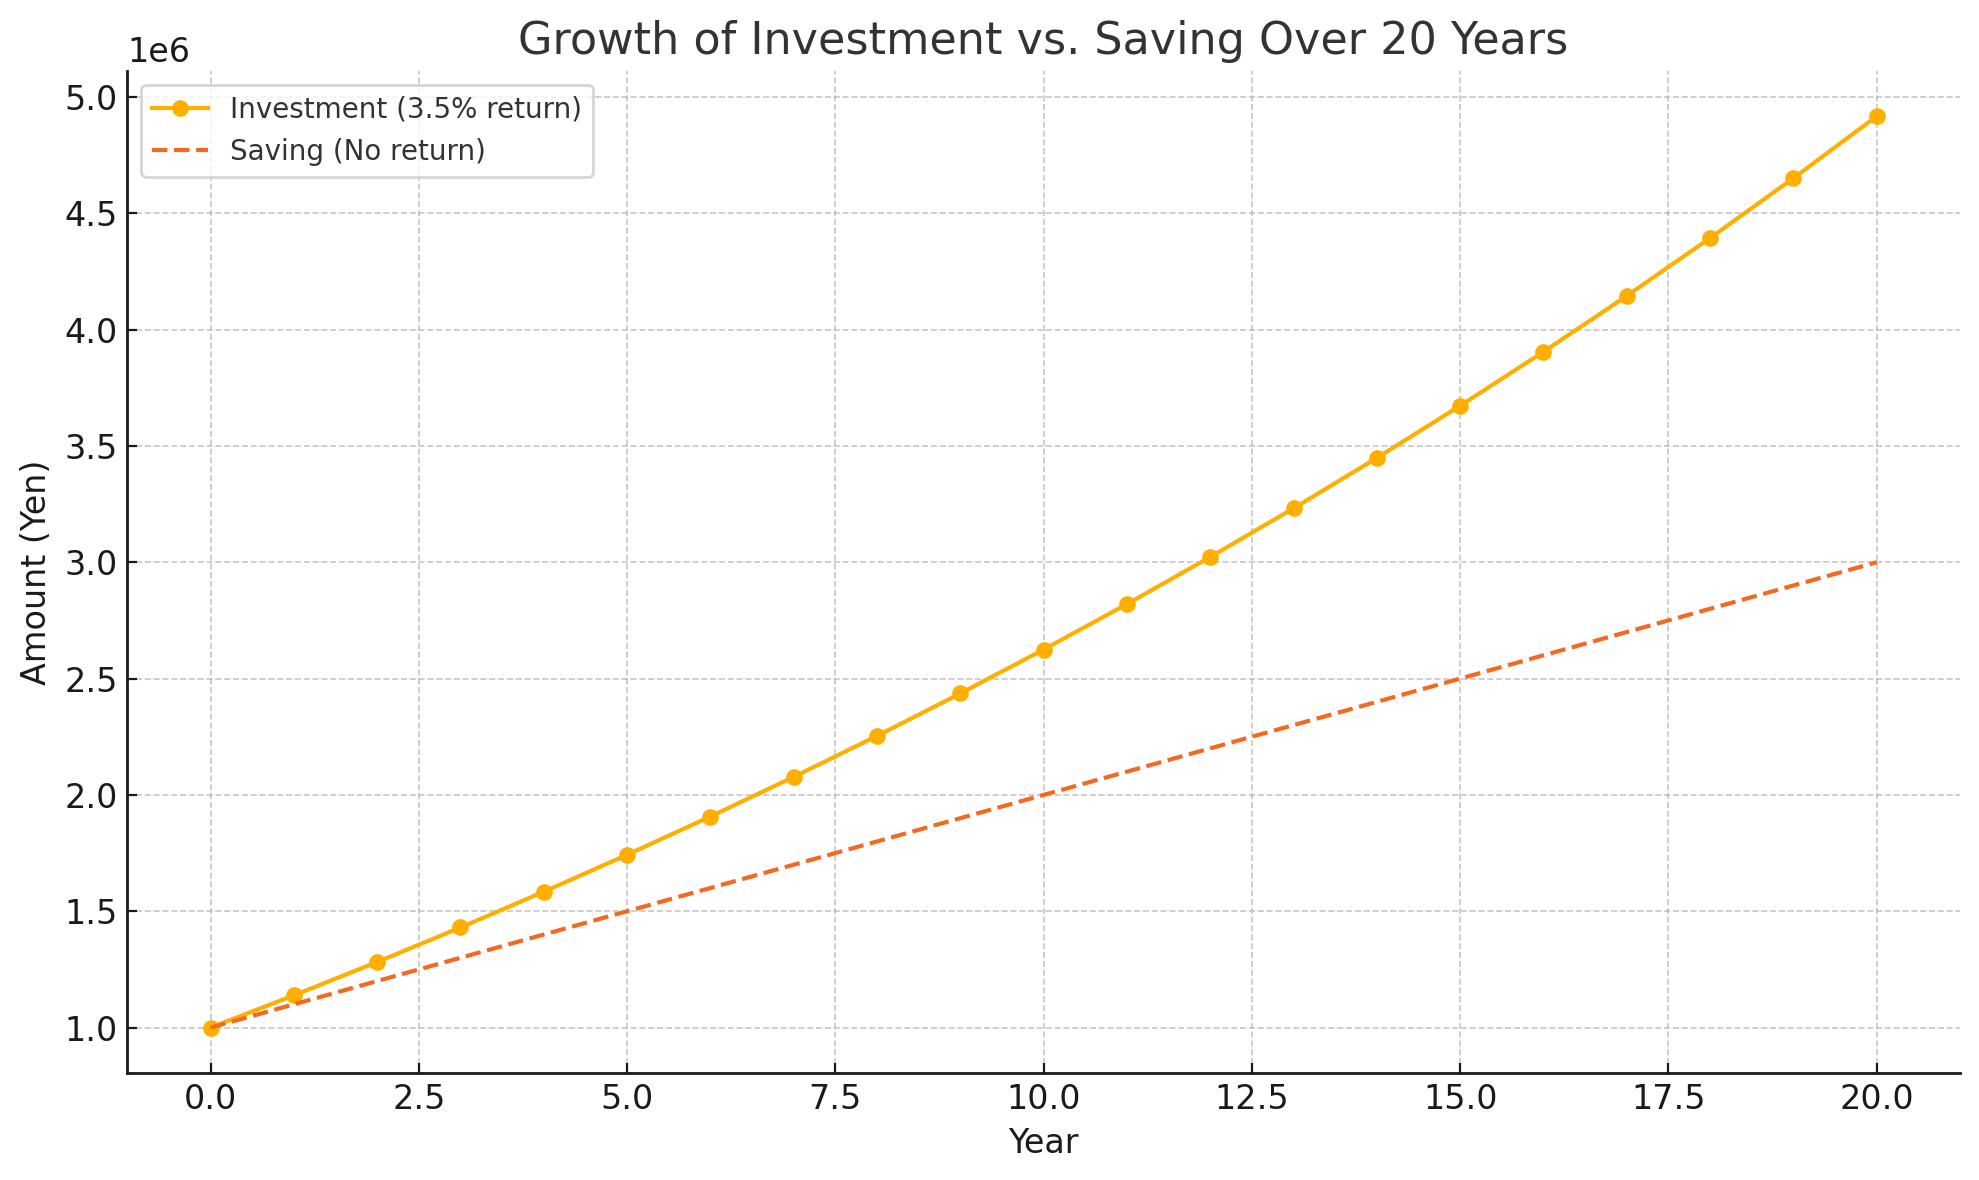

In [15]:
message= (
    "初期投資額が100万円、年利回りが3.5%、毎年10万円ずつ追加投資を"
    "20年間継続したときの最終的な資産額を計算し、円単位で四捨五入して答えてください。"
    "また、投資せずに貯蓄した場合と比較できるようグラフを出力してください。ラベルやタイトルは英語で出力してください。"
)


response = await agent.get_response(
    messages=[message],
    thread=thread,
)

await agent_run_outputs(thread.id, project_client.agents)

In [16]:
await agent_run_outputs(thread.id, project_client.agents, show_tool_calls=True, run_id=run.id)

NameError: name 'run' is not defined

# Agent ID を .env ファイルに保存

今回作成したエージェントを後続のハンズオン演習で使用するため、エージェントIDを永続化します。

In [ ]:
# 変数の定義
agent_env_key = "FOUNDRY_CODE_INTERPRETER_AGENT_ID"
agent_env_value = code_interpreter_agent_definition.id

# .envファイルのパスを自動探索
env_path = find_dotenv()  # 見つからなければ''を返す
if not env_path:
    raise FileNotFoundError(".envファイルが見つかりませんでした。")

# AGENT_ID を .env ファイルに追記
with open(env_path, "a", encoding="utf-8") as f:
    f.write(f'\n{agent_env_key}="{agent_env_value}"')

print(f'.envファイルに {agent_env_key}=\"{agent_env_value}\" を追記しました。')


.envファイルに FOUNDRY_CODE_INTERPRETER_AGENT_ID="asst_PhSwcdYKIPPJJ1PForbcRZa0" を追記しました。
